This notebook contains code building a Regression model to predict the tip amount of the New York taxis.
Data source: https://registry.opendata.aws/nyc-tlc-trip-records-pds/

In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
# install the necessary packages
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.11.0")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1684205804460_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/59/60/163503f24cf09553d0bb6c37db9ff3254f6cda812cab00430602867d03f5/boto3-1.19.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6a/73/552b27e3a1b4f83630907c4958be78e9d4c906e73efd554ebd5e21cb1692/botocore-1.22.12-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/9c/f51775ebe7df5a7aa4e7c79ed671bde94e154bd968aca8d65bb24aba0c8c/s3transfer-0.5.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/f5/890a0baca17a61c1f92f72b81d3c31523c99bec609e60c292ea55b387ae8/urllib3-1.26.15-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.

In [3]:
# import packages/functions
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
df = spark.read.parquet('s3://nyc-tlc/trip data/yellow_tripdata_2019*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)

In [9]:
# number of rows
df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

84598444

In [10]:
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2019-03-01 00:24:41|  2019-03-01 00:25:31|            1.0|          0.0|       1.0|                 N|         145|         145|           2|        2.5|  0.5|    0.5|       0.

# Feature Engineering

In [11]:
# Check missing values in each column
missing_values = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the results
missing_values.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         444383|            0|    444383|            444383|           0|           0|           0|          0|    0|      0|         

It seems like passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge, and airport_fee are the only columns with missing values. 
Interestingly, airport_fee seems like all null values.
I'm not going to include congestion_surcharge and airport_fee because of the significant number of missing values.

## Feature engineering: ride_duration

In [18]:
# calculate ride duration in seconds
df = df.withColumn('ride_duration', (F.unix_timestamp('tpep_dropoff_datetime') - F.unix_timestamp('tpep_pickup_datetime')).cast('int'))

# show distribution of ride durations
df.select('ride_duration').describe().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|     ride_duration|
+-------+------------------+
|  count|          84598444|
|   mean|1084.0334850012134|
| stddev|  6025.28052642268|
|    min|         -31527629|
|    max|           2618881|
+-------+------------------+

In [6]:
# inspect the rows with non-positive values for 'ride_duration' 
df.filter(F.col('ride_duration') <= 0).show(5)

# all of these have a 0 duration, therefore I'll fiter out the rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|ride_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+
|       1| 2019-03-01 00:20:38|  2019-03-01 00:20:38|            1.0|          0.0|       1.0|                 Y|         107|         264|      

In [19]:
# filter out rows with non-positive ride_duration
df = df.filter(F.col('ride_duration') > 0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Feature engineering: passenger_count

In [14]:
# check the percentage of null value rows
df.filter(F.col('passenger_count').isNull()).count()/df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.005223883678526089

In [20]:
# since it's not a significant amount considering the data size
# drop the missing value rows
df = df.dropna(subset=['passenger_count'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

passenger_count: This feature is included in the model because the number of passengers may affect the tip amount, as larger groups may tend to give higher tips.

## Feature engineering: trip_distance

In [23]:
# inspect the rows with non-positive values for 'trip_distance' 
df.filter(F.col('trip_distance') <= 0).select('trip_distance').show(5)

# similarly, all of these have a 0 duration, therefore I'll fiter out the rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|trip_distance|
+-------------+
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
+-------------+
only showing top 5 rows

In [21]:
# filter out rows with non-positive trip_distance
df = df.filter(F.col('trip_distance') > 0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

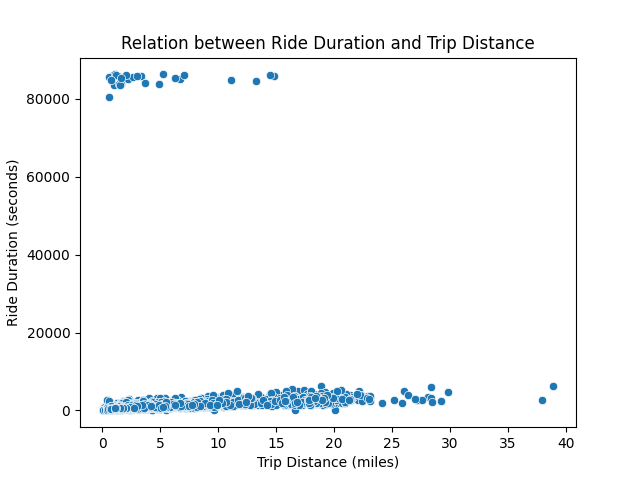

In [17]:
# Explore the relations between ride_duration and trip_distance
# extract a random sample of the dataframe
sample_df = df.select('ride_duration', 'trip_distance').sample(False, 0.0001, seed=42)

# convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = sample_df.toPandas()

plt.close()
# create the scatter plot using seaborn
ax = sns.scatterplot(data=pandas_df, x='trip_distance', y='ride_duration')
ax.set_title('Relation between Ride Duration and Trip Distance')
ax.set_ylabel('Ride Duration (seconds)')
ax.set_xlabel('Trip Distance (miles)')
# show the plot
plt.show()

%matplot plt

In [22]:
# seems like the ridiculously high value of ride durations is due to recording errors
# filter out trip_duration higher than 70,000 
df = df.filter(F.col('ride_duration') < 70000)

df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

83206133

trip_distance: This feature is included as the distance of the trip may influence the tip amount, as longer trips may result in higher tips.

## Analyzing Payment Type

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

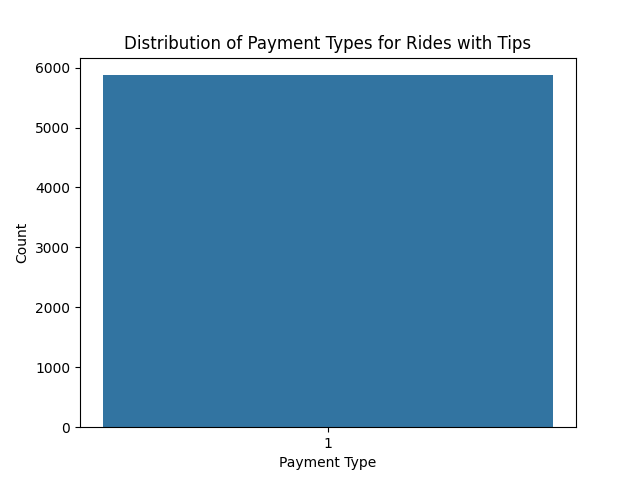

In [29]:
# filter out rows with tip_amount equals zero
df_filtered = df.filter(F.col('tip_amount') != 0).sample(False, 0.0001, seed=42)

# group the dataframe by payment_type and count the number of occurrences of VendorID
payment_counts = df_filtered.groupBy('payment_type').agg(F.count('VendorID').alias('count'))

# convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = payment_counts.toPandas()

plt.close()
# create the bar plot using seaborn
ax = sns.barplot(data=pandas_df, x='payment_type', y='count')
ax.set_title('Distribution of Payment Types for Rides with Tips')
ax.set_ylabel('Count')
ax.set_xlabel('Payment Type')

# show the plot
plt.show()

%matplot plt

We see that only payment type 1 is used for all trips with tips. Therefore, it's not really interesting to include payment type as a feature.

# Analyzing 'extra'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

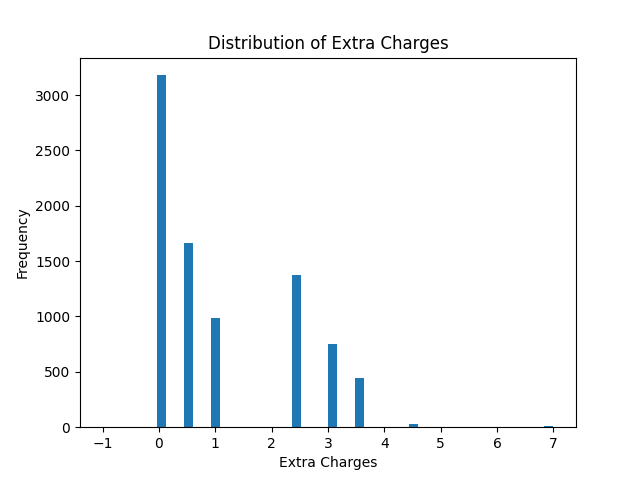

In [32]:
# Convert the 'tip_amount' column to a Pandas Series
target = df.select('extra').sample(False, 0.0001, seed=42).toPandas()['extra']

plt.close()
# Plot the distribution using a histogram
plt.hist(target, bins=50)
plt.xlabel('Extra Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Extra Charges')
plt.show()

%matplot plt

In [23]:
# filter out 'extra' of negative values
df = df.filter(F.col('extra') >= 0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

extra: This feature is included as the extra charge of the trip may influence the tip amount, as more extra charge may result in more service provided and higher tips.

# Selecting Features

The reasoning of dropping the following columns are the followings:
- 'payment_type': only payment type 1 would pay tips
- 'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'mta_tax', 'improvement_surcharge': not relevant to tip amounts
- 'tpep_pickup_datetime', 'tpep_dropoff_datetime': transformed to 'ride_duration'
- 'airport_fee': no data


In [24]:
# drop the non-feature variables
df_select = df.drop('payment_type', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
                 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'airport_fee', 
                 'mta_tax', 'improvement_surcharge')

df_select.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- ride_duration: integer (nullable = true)

In [25]:
df_select.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-------------+-----------+-----+----------+------------+------------+--------------------+-------------+
|passenger_count|trip_distance|fare_amount|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge|ride_duration|
+---------------+-------------+-----------+-----+----------+------------+------------+--------------------+-------------+
|            2.0|          3.7|       13.0|  0.5|       0.7|         0.0|        15.0|                 0.0|          670|
|            1.0|         14.1|       41.0|  3.0|      10.1|        5.76|       60.66|                 2.5|         1982|
|            1.0|          9.6|       27.0|  0.5|       0.0|         0.0|        28.3|                 0.0|         1028|
|            1.0|          0.8|        5.5|  3.0|       3.0|         0.0|        12.3|                 2.5|          298|
|            1.0|          1.2|        6.0|  3.0|       0.0|         0.0|         9.8|                 2.5|          275|
+---------------+-------

In [26]:
df_select.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

83132973

## Check for collinearity

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

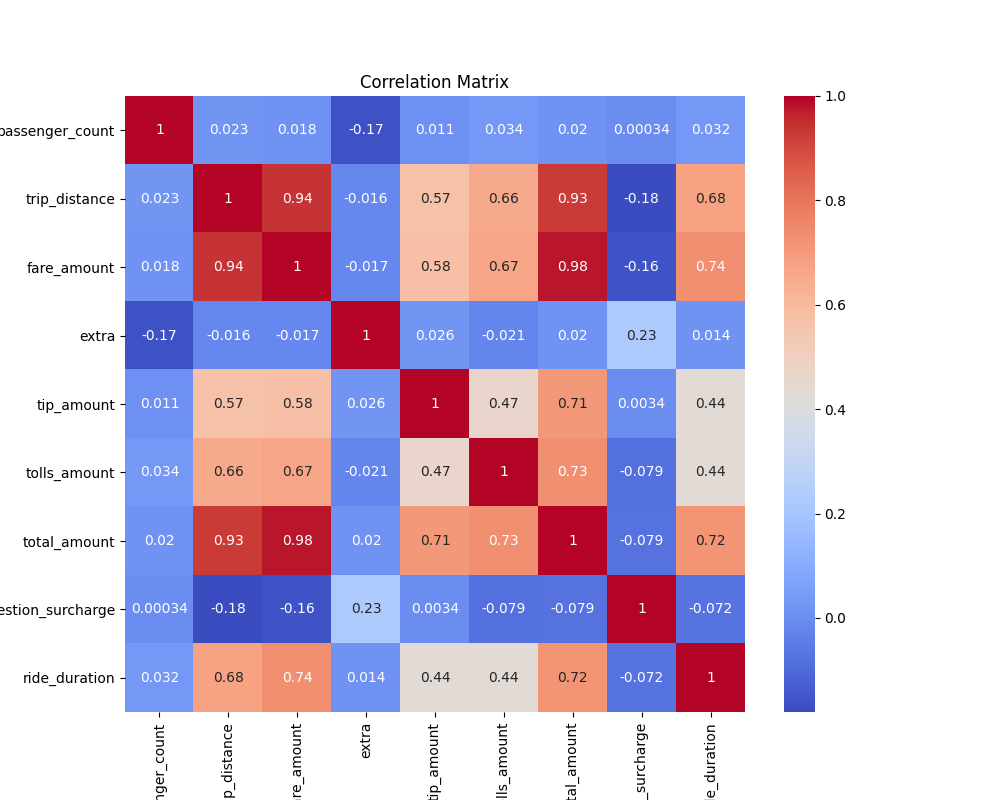

In [27]:
# Calculate the correlation matrix
corr_matrix = df_select.sample(False, 0.0001, seed=42).toPandas().corr()

plt.close()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

%matplot plt

Several feature variables are highly correlated. 
- trip_distance, fare_amount, and total_amount are highly correlated (r>.90)

Considering the interpretability, I'm going to keep fare_amount out of the three price-related variables. 

In [28]:
df_select = df_select.drop('trip_distance', 'total_amount')

df_select.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- passenger_count: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- ride_duration: integer (nullable = true)

In [38]:
# Check missing values in each column
missing_values = df_select.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_select.columns])

# Show the results
missing_values.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-----------+-----+----------+------------+--------------------+-------------+
|passenger_count|fare_amount|extra|tip_amount|tolls_amount|congestion_surcharge|ride_duration|
+---------------+-----------+-----+----------+------------+--------------------+-------------+
|              0|          0|    0|         0|           0|             4806686|            0|
+---------------+-----------+-----+----------+------------+--------------------+-------------+

In [40]:
# calculate the percentage of missing values
df_select.filter(F.col('congestion_surcharge').isNull()).count()/df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.05781924820612394

In [41]:
# drop the rows with missing values
df_select = df_select.dropna(subset=['congestion_surcharge'])

df_select.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

78326287

# Exploring target variable 'tip_amount'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

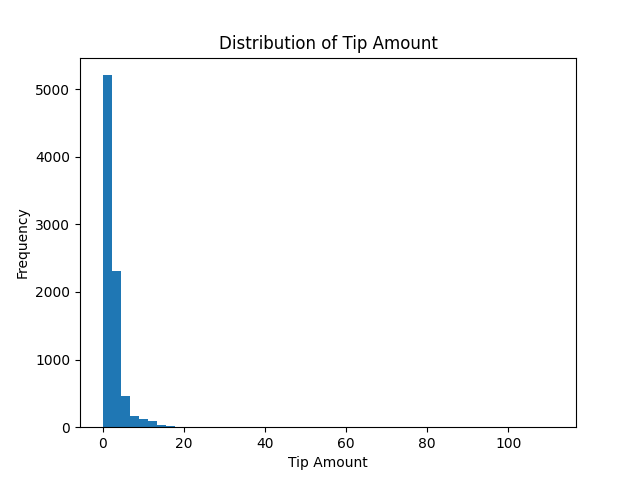

In [20]:
# Convert the 'tip_amount' column to a Pandas Series
target = df.select('tip_amount').sample(False, 0.0001, seed=42).toPandas()['tip_amount']

plt.close()
# Plot the distribution using a histogram
plt.hist(target, bins=50)
plt.xlabel('Tip Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Tip Amount')
plt.show()

%matplot plt

# Fit a Ridge regression model (model 1)

In [30]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
# Split the data into training and testing sets
train_data, test_data = df_select.randomSplit([0.7, 0.3], seed=42)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
feature_cols = [col for col in df_select.columns if col != 'tip_amount']
feature_cols

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['passenger_count', 'fare_amount', 'extra', 'tolls_amount', 'congestion_surcharge', 'ride_duration']

In [52]:
# Define the feature vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Apply the feature vector assembler to the training and testing data
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
# Create a LinearRegression model with Ridge regularization
regression = LinearRegression(labelCol='tip_amount', elasticNetParam=0.0, regParam=0.1)

# Fit the model to the training data
model = regression.fit(train_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# Make predictions on the test data
predictions = model.transform(test_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Model Evaluation

In [56]:
# Evaluate the model's performance using a regression evaluator
evaluator = RegressionEvaluator(labelCol='tip_amount')
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE): 2.630222984796276
R-squared (R2): 0.0954752763819181

The RMSE value of 2.630 indicates that, on average, the model's predictions have an error of approximately 2.630 units in the same scale as the target variable (tip_amount).

The R-squared value of 0.095 indicates that the model explains only about 9.5% of the variance in the target variable. 

Based on these performance metrics, the model's performance is not satisfactory. It has a high RMSE and a low R-squared, indicating that the model's predictions are not accurate and it fails to explain a significant portion of the target variable's variance. 

In [59]:
model.coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([-0.0142, 0.0067, 0.0113, 0.4925, 0.1553, 0.0007])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

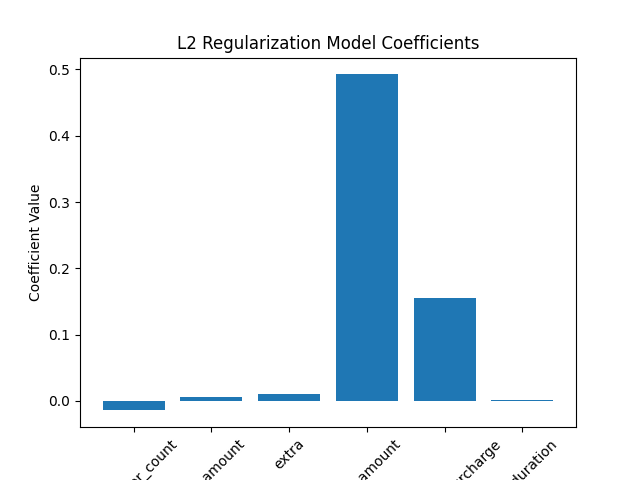

In [61]:
# Get the coefficient values from the model
coefficients = model.coefficients

plt.close()
# Create a bar chart to visualize the coefficients
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(range(len(coefficients)), feature_cols, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('L2 Regularization Model Coefficients')
plt.show()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

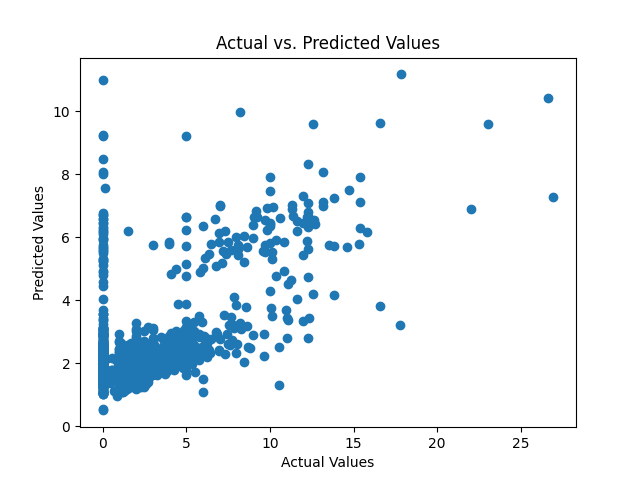

In [62]:
# Extract the predicted and actual values from the DataFrame
pred_subset = predictions.sample(False, 0.0001, seed=42)
predicted_values = pred_subset.select('prediction').rdd.flatMap(lambda x: x).collect()
actual_values = pred_subset.select('tip_amount').rdd.flatMap(lambda x: x).collect()

plt.close()
# Plot the predicted values versus the actual values
plt.scatter(actual_values, predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

%matplot plt

It seems that when tip amount is 0, the model can't correctly predict. Therefore, I'm making a subset of tip amount that is not zero and re-training the model.

# Improving model performance

In [66]:
# select the rows where tip amount is larger than 0
df_select2 = df_select.filter(F.col('tip_amount') > 0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# Split the data into training and testing sets
train_data, test_data = df_select2.randomSplit([0.7, 0.3], seed=42)

feature_cols = [col for col in df_select2.columns if col != 'tip_amount']

# Define the feature vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Apply the feature vector assembler to the training and testing data
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Create a LinearRegression model with Ridge regularization
regression = LinearRegression(labelCol='tip_amount', elasticNetParam=0.0, regParam=0.1)

# Fit the model to the training data
model = regression.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance using a regression evaluator
evaluator = RegressionEvaluator(labelCol='tip_amount')
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE): 1.5942872098580012
R-squared (R2): 0.6740851010505056

Excluding zero tip amounts has significantly improved the model's performance, indicating its ability to accurately predict tip amounts when guests do give tips.

The Root Mean Squared Error (RMSE) of 1.594 indicates that, on average, the model's predictions deviate from the actual tip amounts by approximately 1.594 units. This value represents the measure of the model's overall prediction accuracy, with lower values indicating better performance.

The R-squared (R2) value of 0.674 suggests that approximately 67.4% of the variance in the tip amounts can be explained by the features included in the model. This metric indicates the goodness of fit of the model, with higher values indicating a better fit.

Overall, the RMSE and R2 values indicate that the model performs reasonably well in predicting tip amounts, with moderate accuracy and a satisfactory level of explained variance.

In [72]:
# Get the coefficient values from the model
coefficients = model.coefficients

coefficients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([0.0093, 0.1606, 0.008, 0.2631, 0.1008, 0.0002])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

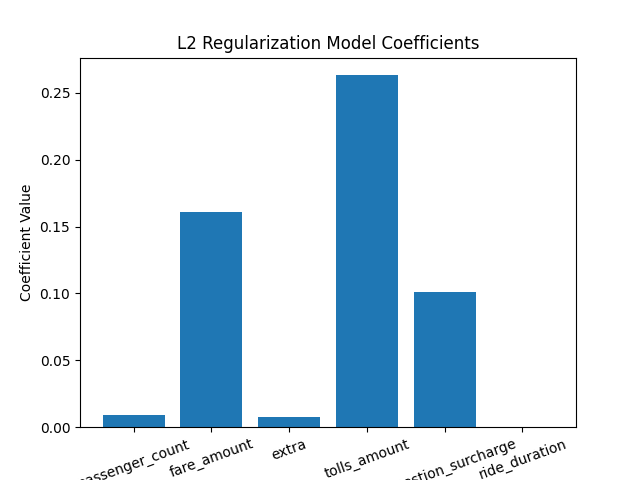

In [70]:
plt.close()
# Create a bar chart to visualize the coefficients
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(range(len(coefficients)), feature_cols, rotation=20)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('L2 Regularization Model Coefficients')
plt.show()

%matplot plt

Toll amount paid and base fare amount (highly correlated with trip distance) for the trip are found to be the most relevant features.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

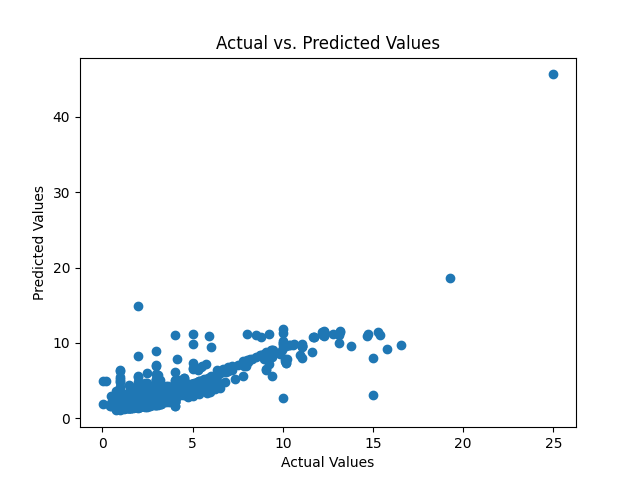

In [71]:
# Extract the predicted and actual values from the DataFrame
pred_subset = predictions.sample(False, 0.0001, seed=42)
predicted_values = pred_subset.select('prediction').rdd.flatMap(lambda x: x).collect()
actual_values = pred_subset.select('tip_amount').rdd.flatMap(lambda x: x).collect()

plt.close()
# Plot the predicted values versus the actual values
plt.scatter(actual_values, predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

%matplot plt

The plot indicates that performance would improve further if outliers were removed.